---
# Projeto I - MLP

In [1]:
# Bibliotecas utilizadas
from src.mlp import MLP

from math import ceil, log
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def projeto(X_data:pd.DataFrame, y_data:pd.DataFrame, eta:list=[0.01, 0.5, 0.99], alpha:list=[0, 0.5, 1], test_size:float=0.3, n_camadas:int=1, max_epocas:int=50, seed=42):
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=seed, shuffle=True)
    print('treino', X_train.shape, y_train.shape)
    print('teste', X_test.shape, y_test.shape)

    fig, axs = plt.subplots(len(eta), len(alpha), sharex=True, sharey=True)
    fig.set_figheight(2*len(eta))
    fig.set_figwidth(4*len(alpha))

    camadas = [len(X_train[0])]
    # camadas += [2*len(X_train[0]) for _ in range(n_camadas)] # camadas intermediarias com muitos neuronios otimo pra classificação, pessimo pra regressão
    camadas += [ceil(log(len(X_train[0]))) for _ in range(n_camadas)]
    camadas += [len(y_train[0])]
    for i, eta_i in enumerate(eta):
        for j, alpha_i in enumerate(alpha):
            rede = MLP(camadas=camadas,seed=seed)
            err = rede.treino(X=X_train, Y=y_train, taxa=eta_i, alpha=alpha_i, max_epocas=max_epocas)
            MSE = rede.teste(X=X_test, Y=y_test)
            axs[i,j].set_title('eta:{:.1f}    alpha:{:.1f}'.format(eta_i, alpha_i))
            axs[i,j].plot(err)
            axs[i,j].plot(len(err)-1, MSE, ls=None, marker='x', c='red')
            print('eta:{:.1f}    alpha:{:.1f}    MSE(treino):{:.5f}    MSE(teste):{:.5f}'.format(eta_i, alpha_i, err[-1], MSE))
    plt.show()

    return

In [3]:
# debug
def debug(data, X_data, y_data, tam_resp, camadas:list, n_tests:int=20,  seed:int=321):
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=seed, shuffle=True)
    rede = MLP(camadas=camadas)
    _ = rede.treino(X=X_data, Y=y_data, taxa=0.5, alpha=0.5, max_epocas=100)

    debug = np.random.randint(size=n_tests, low=0, high=len(data))
    for v in debug:
        debug_x = [np.array(data.iloc[v,:-tam_resp])]
        debug_y = [np.array(data.iloc[v,-tam_resp:])]
        
        saida, _ = rede.feedforward(debug_x)
        print(debug_y, saida)
    return

---
# Parte I - Classificação

---
## Tratamento Dados - Wine

---
### Importando Dados

In [4]:
cols = [
    'class', 'alcohol', 'malic acid', 'ash', 'alkalinity of ash', 'magnesium', 'total phenols',
    'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'OD', 'proline'
]

In [5]:
# Carregando os dados em um dataframe
wine_df = pd.read_csv('data/wine.data', names=cols)
wine_df.head()

,class,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# classificando a variavel resposta
wine_df['class'] = wine_df['class'].astype('category')
wine_df = pd.get_dummies(wine_df, columns=['class'])
wine_df.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline,class_1,class_2,class_3
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,0,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,0,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,0,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,0,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,0,0


In [7]:
# Verificação de valores faltantes
# Retorna "True" caso haja pelo menos uma coluna com valores faltantes na base.
# Caso contrário, retorna "False"
any(wine_df.isna().sum() > 0)

False

In [8]:
# Verificação de valores duplicados
# Retorna "True" caso haja pelo menos uma instância duplicada na base.
# Caso contrário, retorna "False"
any(wine_df.duplicated())

False

---
### Normalização

In [9]:
# Normalização dos dados
scaler = MinMaxScaler()
wine_norm = scaler.fit_transform(wine_df)
wine_norm = pd.DataFrame(wine_norm)
wine_norm.columns = wine_df.columns
wine_norm.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline,class_1,class_2,class_3
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,1.0,0.0,0.0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,1.0,0.0,0.0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,1.0,0.0,0.0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,1.0,0.0,0.0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,1.0,0.0,0.0


---
### Separação X, y

In [10]:
# Separando as variavis explicativas da variavel resposta
wine_X = wine_norm.drop(columns=['class_1','class_2','class_3'])
wine_y = wine_norm[['class_1','class_2','class_3']]

In [11]:
wine_X.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [12]:
wine_y.head()

,class_1,class_2,class_3
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [13]:
wine_X.describe()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.518584,0.315484,0.538244,0.458502,0.323278,0.453487,0.356386,0.437460,0.372523,0.322363,0.388170,0.491460,0.334446
std,0.213639,0.220780,0.146708,0.172142,0.155244,0.215811,0.210730,0.234818,0.180555,0.197806,0.185831,0.260070,0.224613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350658,0.170455,0.454545,0.340206,0.195652,0.262931,0.182489,0.264151,0.264984,0.165529,0.245935,0.244505,0.158702
50%,0.531579,0.222332,0.534759,0.458763,0.304348,0.474138,0.378692,0.396226,0.361199,0.290956,0.394309,0.553114,0.282097
75%,0.696711,0.462945,0.640374,0.561856,0.402174,0.627586,0.534810,0.580189,0.485804,0.419795,0.520325,0.695971,0.504280
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
wine_y.describe()

,class_1,class_2,class_3
count,178.000000,178.000000,178.000000
mean,0.331461,0.398876,0.269663
std,0.472066,0.491049,0.445037
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


---
## Aplicação

---
### 1 camada

treino (71, 13) (71, 3)
teste (107, 13) (107, 3)
eta:0.1    alpha:0.0    MSE(treino):0.25936    MSE(teste):0.30005
eta:0.1    alpha:0.3    MSE(treino):0.16933    MSE(teste):0.20855
eta:0.1    alpha:0.5    MSE(treino):0.13540    MSE(teste):0.17355
eta:0.1    alpha:0.7    MSE(treino):0.11242    MSE(teste):0.14996
eta:0.1    alpha:1.0    MSE(treino):0.08946    MSE(teste):0.12684
eta:0.5    alpha:0.0    MSE(treino):0.02869    MSE(teste):0.06817
eta:0.5    alpha:0.3    MSE(treino):0.02063    MSE(teste):0.06043
eta:0.5    alpha:0.5    MSE(treino):0.01705    MSE(teste):0.05737
eta:0.5    alpha:0.7    MSE(treino):0.01434    MSE(teste):0.05530
eta:0.5    alpha:1.0    MSE(treino):0.01138    MSE(teste):0.05328
eta:0.9    alpha:0.0    MSE(treino):0.01315    MSE(teste):0.05451
eta:0.9    alpha:0.3    MSE(treino):0.00909    MSE(teste):0.05184
eta:0.9    alpha:0.5    MSE(treino):0.00747    MSE(teste):0.05087
eta:0.9    alpha:0.7    MSE(treino):0.00631    MSE(teste):0.05022
eta:0.9    alpha:1.0    MSE

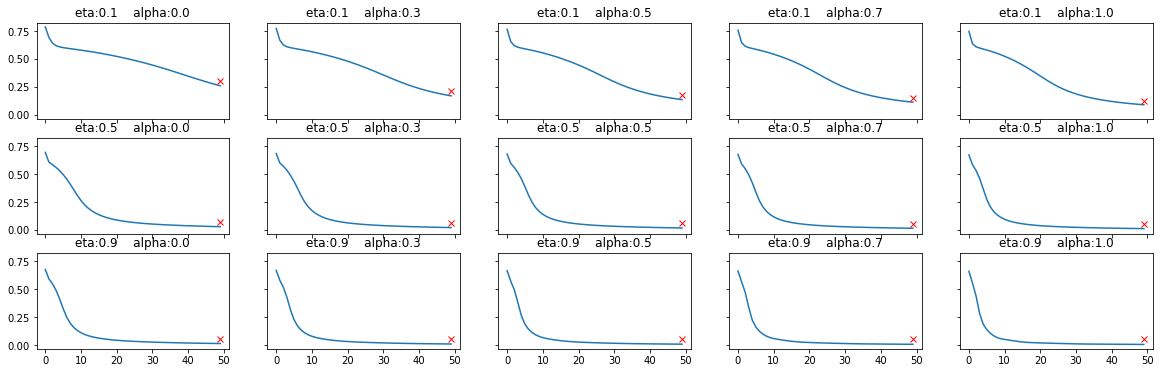

In [15]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 1,
    seed = 100
)

treino (142, 13) (142, 3)
teste (36, 13) (36, 3)
eta:0.1    alpha:0.0    MSE(treino):0.10986    MSE(teste):0.12962
eta:0.1    alpha:0.3    MSE(treino):0.07547    MSE(teste):0.10253
eta:0.1    alpha:0.5    MSE(treino):0.06227    MSE(teste):0.09170
eta:0.1    alpha:0.7    MSE(treino):0.05291    MSE(teste):0.08358
eta:0.1    alpha:1.0    MSE(treino):0.04299    MSE(teste):0.07427
eta:0.5    alpha:0.0    MSE(treino):0.01469    MSE(teste):0.04153
eta:0.5    alpha:0.3    MSE(treino):0.01136    MSE(teste):0.03701
eta:0.5    alpha:0.5    MSE(treino):0.00991    MSE(teste):0.03530
eta:0.5    alpha:0.7    MSE(treino):0.00880    MSE(teste):0.03423
eta:0.5    alpha:1.0    MSE(treino):0.00750    MSE(teste):0.03343
eta:0.9    alpha:0.0    MSE(treino):0.00837    MSE(teste):0.03786
eta:0.9    alpha:0.3    MSE(treino):0.00640    MSE(teste):0.03785
eta:0.9    alpha:0.5    MSE(treino):0.00559    MSE(teste):0.03936
eta:0.9    alpha:0.7    MSE(treino):0.00437    MSE(teste):0.03690
eta:0.9    alpha:1.0    MSE

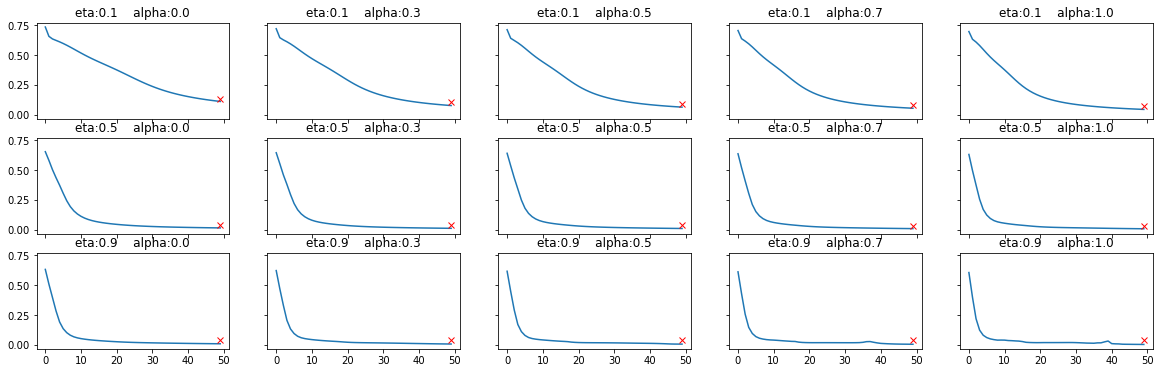

In [16]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 1,
    seed = 100
)

---
### 2 camadas

treino (71, 13) (71, 3)
teste (107, 13) (107, 3)
eta:0.1    alpha:0.0    MSE(treino):0.50861    MSE(teste):0.61849
eta:0.1    alpha:0.3    MSE(treino):0.37642    MSE(teste):0.48898
eta:0.1    alpha:0.5    MSE(treino):0.32830    MSE(teste):0.44179
eta:0.1    alpha:0.7    MSE(treino):0.30224    MSE(teste):0.41779
eta:0.1    alpha:1.0    MSE(treino):0.28082    MSE(teste):0.40049
eta:0.5    alpha:0.0    MSE(treino):0.08916    MSE(teste):0.12106
eta:0.5    alpha:0.3    MSE(treino):0.02534    MSE(teste):0.04373
eta:0.5    alpha:0.5    MSE(treino):0.01565    MSE(teste):0.03503
eta:0.5    alpha:0.7    MSE(treino):0.01091    MSE(teste):0.03194
eta:0.5    alpha:1.0    MSE(treino):0.00729    MSE(teste):0.03079
eta:0.9    alpha:0.0    MSE(treino):0.01524    MSE(teste):0.03384
eta:0.9    alpha:0.3    MSE(treino):0.00676    MSE(teste):0.03074
eta:0.9    alpha:0.5    MSE(treino):0.00465    MSE(teste):0.03221
eta:0.9    alpha:0.7    MSE(treino):0.00331    MSE(teste):0.03442
eta:0.9    alpha:1.0    MSE

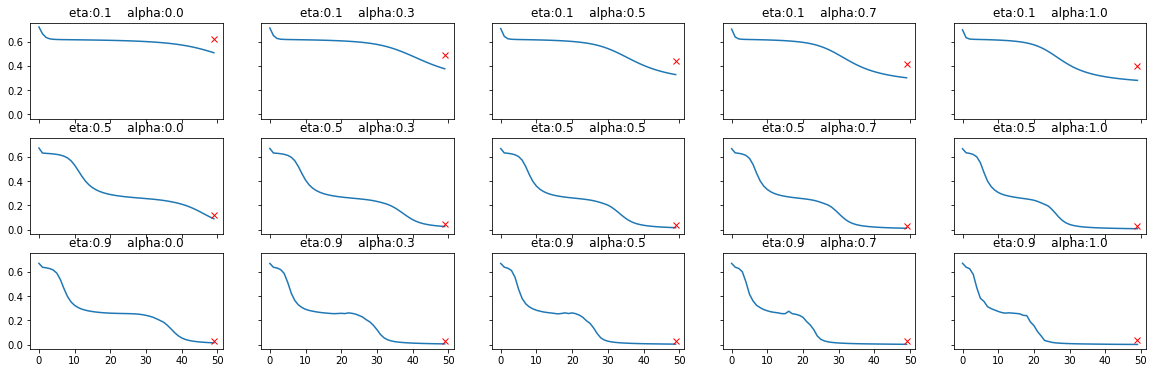

In [17]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 2,
    seed = 100
)

treino (142, 13) (142, 3)
teste (36, 13) (36, 3)
eta:0.1    alpha:0.0    MSE(treino):0.33730    MSE(teste):0.39507
eta:0.1    alpha:0.3    MSE(treino):0.22807    MSE(teste):0.26771
eta:0.1    alpha:0.5    MSE(treino):0.13272    MSE(teste):0.14181
eta:0.1    alpha:0.7    MSE(treino):0.08407    MSE(teste):0.08053
eta:0.1    alpha:1.0    MSE(treino):0.05146    MSE(teste):0.04731
eta:0.5    alpha:0.0    MSE(treino):0.00716    MSE(teste):0.01375
eta:0.5    alpha:0.3    MSE(treino):0.00506    MSE(teste):0.01525
eta:0.5    alpha:0.5    MSE(treino):0.00411    MSE(teste):0.02137
eta:0.5    alpha:0.7    MSE(treino):0.00353    MSE(teste):0.02901
eta:0.5    alpha:1.0    MSE(treino):0.00711    MSE(teste):0.04169
eta:0.9    alpha:0.0    MSE(treino):0.00665    MSE(teste):0.03686
eta:0.9    alpha:0.3    MSE(treino):0.00645    MSE(teste):0.04764
eta:0.9    alpha:0.5    MSE(treino):0.00218    MSE(teste):0.02706
eta:0.9    alpha:0.7    MSE(treino):0.00061    MSE(teste):0.01355
eta:0.9    alpha:1.0    MSE

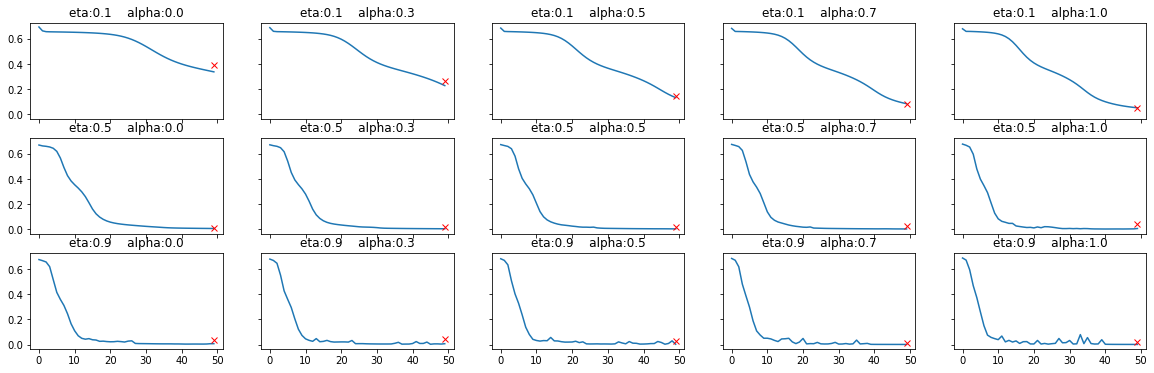

In [18]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 2,
    seed = 100
)

---
# Parte II - Regressão

## Tratamento Dados - Musica

As 68 primeiras colunas se referem a recursos de áudio da música, e as duas últimas se referem ao local de origem da música, representado pela latitude e longitude, respectivamente.

### Importando dados

In [19]:
# Carregando os dados em um dataframe
music_df = pd.read_csv('data/default_features_1059_tracks.txt', header=None)
music_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-1.504263,0.351267,-1.018726,-0.174878,-1.089543,-0.668840,-0.914772,-0.836250,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,-0.495712,-0.465077,-0.157861,-0.157189,0.380951,1.088478,-0.123595,1.391141,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,-0.637167,0.147260,0.217914,2.718442,0.972919,2.081069,1.375763,1.063847,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,-0.178325,-0.065059,-0.724247,-1.020687,-0.751380,-0.385005,-0.012326,-0.392197,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,-0.919463,-0.667912,-0.820172,-0.190488,0.306974,0.119658,0.271838,1.289783,34.03,-6.85


In [20]:
# Verificação de valores faltantes
# Retorna "True" caso haja pelo menos uma coluna com valores faltantes na base.
# Caso contrário, retorna "False"
any(music_df.isna().sum() > 0)

False

In [21]:
# Verificação de valores duplicados
# Retorna "True" caso haja pelo menos uma instância duplicada na base.
# Caso contrário, retorna "False"
any(music_df.duplicated())

False

---
### Normalização

In [22]:
music_scaler = MinMaxScaler()
music_norm = music_scaler.fit_transform(music_df)
music_norm = pd.DataFrame(music_norm)
music_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.792304,0.763528,0.554789,0.459774,0.332975,0.312870,0.694223,0.485061,0.772537,0.621409,...,0.010367,0.279176,0.059900,0.180836,0.046037,0.075438,0.046425,0.067519,0.217271,0.171557
1,0.160018,0.113349,0.072690,0.406624,0.751846,0.641129,0.601004,0.522885,0.619012,0.653455,...,0.122493,0.161148,0.146472,0.183240,0.260799,0.304061,0.166138,0.372358,0.558013,0.274298
2,0.076301,0.078613,0.047402,0.484945,0.437505,0.722346,0.670107,0.545760,0.474494,0.498113,...,0.106767,0.249681,0.184261,0.573916,0.347254,0.433194,0.393006,0.327565,0.532896,0.339499
3,0.072377,0.064981,0.437753,0.430514,0.595593,0.712046,0.825708,0.641975,0.647266,0.667595,...,0.157779,0.218983,0.089514,0.065927,0.095425,0.112365,0.182974,0.128292,0.492665,0.535985
4,0.191425,0.143468,0.117185,0.361344,0.782781,0.481490,0.574164,0.580605,0.477661,0.773414,...,0.075383,0.131821,0.079867,0.178716,0.249995,0.178020,0.225971,0.358486,0.770505,0.344333


---
### Separando X, y

In [23]:
# Separando os atributos
music_X = music_norm.drop(columns=[68,69])
music_y = music_norm[[68,69]]

In [24]:
music_X.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.792304,0.763528,0.554789,0.459774,0.332975,0.312870,0.694223,0.485061,0.772537,0.621409,...,0.080394,0.252689,0.010367,0.279176,0.059900,0.180836,0.046037,0.075438,0.046425,0.067519
1,0.160018,0.113349,0.072690,0.406624,0.751846,0.641129,0.601004,0.522885,0.619012,0.653455,...,0.213051,0.111763,0.122493,0.161148,0.146472,0.183240,0.260799,0.304061,0.166138,0.372358
2,0.076301,0.078613,0.047402,0.484945,0.437505,0.722346,0.670107,0.545760,0.474494,0.498113,...,0.102961,0.172823,0.106767,0.249681,0.184261,0.573916,0.347254,0.433194,0.393006,0.327565
3,0.072377,0.064981,0.437753,0.430514,0.595593,0.712046,0.825708,0.641975,0.647266,0.667595,...,0.101781,0.285450,0.157779,0.218983,0.089514,0.065927,0.095425,0.112365,0.182974,0.128292
4,0.191425,0.143468,0.117185,0.361344,0.782781,0.481490,0.574164,0.580605,0.477661,0.773414,...,0.198040,0.181444,0.075383,0.131821,0.079867,0.178716,0.249995,0.178020,0.225971,0.358486


In [25]:
music_y.head()

,68,69
0,0.217271,0.171557
1,0.558013,0.274298
2,0.532896,0.339499
3,0.492665,0.535985
4,0.770505,0.344333


In [26]:
music_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,0.137675,0.119341,0.151387,0.347702,0.602079,0.601651,0.609058,0.629529,0.568848,0.660844,...,0.228568,0.263354,0.180476,0.231270,0.164924,0.207457,0.209170,0.165028,0.188380,0.185051
std,0.090064,0.080855,0.133417,0.107610,0.176360,0.137713,0.141061,0.119754,0.109147,0.098285,...,0.154851,0.158662,0.112526,0.146001,0.101449,0.135914,0.146102,0.130498,0.152983,0.137820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.084041,0.070085,0.073296,0.282204,0.491777,0.513916,0.525338,0.562216,0.516567,0.617680,...,0.116240,0.146175,0.103242,0.130004,0.092673,0.114911,0.103892,0.077568,0.087802,0.091801
50%,0.122649,0.103749,0.114154,0.337469,0.625379,0.602785,0.617482,0.633383,0.580264,0.671376,...,0.187502,0.224180,0.154504,0.198967,0.144016,0.178620,0.170406,0.129550,0.137078,0.140347
75%,0.167894,0.146520,0.177241,0.402418,0.727464,0.692378,0.703896,0.696590,0.635436,0.717582,...,0.297618,0.345902,0.229485,0.298629,0.211424,0.269267,0.276279,0.204955,0.247677,0.230231
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
music_y.describe()

,68,69
count,1059.000000,1059.000000
mean,0.688501,0.534579
std,0.205150,0.211955
min,0.000000,0.000000
25%,0.555234,0.386624
50%,0.766393,0.511140
75%,0.835852,0.686733
max,1.000000,1.000000


---
## Aplicação

---
### 1 camada

treino (423, 68) (423, 2)
teste (636, 68) (636, 2)
eta:0.1    alpha:0.0    MSE(treino):0.08080    MSE(teste):0.07834
eta:0.1    alpha:0.3    MSE(treino):0.07756    MSE(teste):0.07689
eta:0.1    alpha:0.5    MSE(treino):0.07622    MSE(teste):0.07647
eta:0.1    alpha:0.7    MSE(treino):0.07514    MSE(teste):0.07615
eta:0.1    alpha:1.0    MSE(treino):0.07385    MSE(teste):0.07575
eta:0.5    alpha:0.0    MSE(treino):0.06865    MSE(teste):0.07374
eta:0.5    alpha:0.3    MSE(treino):0.06723    MSE(teste):0.07396
eta:0.5    alpha:0.5    MSE(treino):0.06602    MSE(teste):0.07446
eta:0.5    alpha:0.7    MSE(treino):0.06488    MSE(teste):0.07481
eta:0.5    alpha:1.0    MSE(treino):0.06387    MSE(teste):0.07509
eta:0.9    alpha:0.0    MSE(treino):0.06474    MSE(teste):0.07633
eta:0.9    alpha:0.3    MSE(treino):0.06298    MSE(teste):0.07679
eta:0.9    alpha:0.5    MSE(treino):0.06214    MSE(teste):0.07872
eta:0.9    alpha:0.7    MSE(treino):0.06108    MSE(teste):0.08000
eta:0.9    alpha:1.0    M

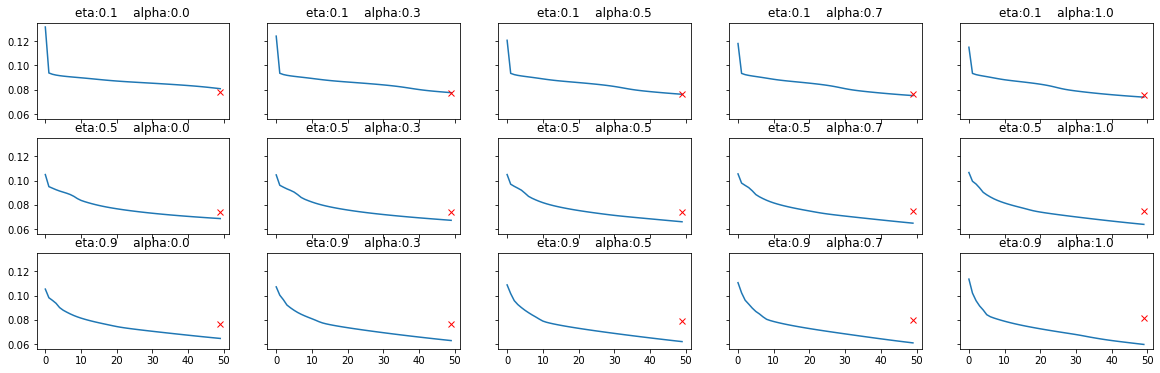

In [28]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 1,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.07551    MSE(teste):0.07102
eta:0.1    alpha:0.3    MSE(treino):0.07387    MSE(teste):0.07040
eta:0.1    alpha:0.5    MSE(treino):0.07297    MSE(teste):0.07012
eta:0.1    alpha:0.7    MSE(treino):0.07217    MSE(teste):0.06989
eta:0.1    alpha:1.0    MSE(treino):0.07114    MSE(teste):0.06964
eta:0.5    alpha:0.0    MSE(treino):0.06682    MSE(teste):0.07038
eta:0.5    alpha:0.3    MSE(treino):0.06612    MSE(teste):0.07046
eta:0.5    alpha:0.5    MSE(treino):0.06551    MSE(teste):0.07024
eta:0.5    alpha:0.7    MSE(treino):0.06500    MSE(teste):0.07025
eta:0.5    alpha:1.0    MSE(treino):0.06445    MSE(teste):0.07037
eta:0.9    alpha:0.0    MSE(treino):0.06487    MSE(teste):0.07072
eta:0.9    alpha:0.3    MSE(treino):0.06379    MSE(teste):0.07082
eta:0.9    alpha:0.5    MSE(treino):0.06296    MSE(teste):0.07077
eta:0.9    alpha:0.7    MSE(treino):0.06100    MSE(teste):0.06986
eta:0.9    alpha:1.0    M

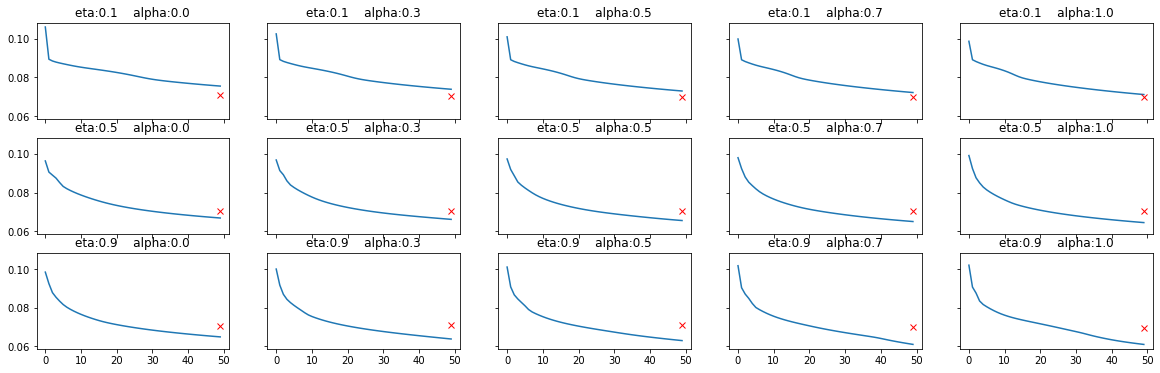

In [29]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 1,
    seed = 100
)

---
### 2 camadas

treino (423, 68) (423, 2)
teste (636, 68) (636, 2)
eta:0.1    alpha:0.0    MSE(treino):0.08899    MSE(teste):0.08484
eta:0.1    alpha:0.3    MSE(treino):0.08827    MSE(teste):0.08445
eta:0.1    alpha:0.5    MSE(treino):0.08755    MSE(teste):0.08406
eta:0.1    alpha:0.7    MSE(treino):0.08659    MSE(teste):0.08359
eta:0.1    alpha:1.0    MSE(treino):0.08500    MSE(teste):0.08285
eta:0.5    alpha:0.0    MSE(treino):0.07574    MSE(teste):0.07656
eta:0.5    alpha:0.3    MSE(treino):0.07283    MSE(teste):0.07464
eta:0.5    alpha:0.5    MSE(treino):0.07127    MSE(teste):0.07390
eta:0.5    alpha:0.7    MSE(treino):0.06992    MSE(teste):0.07410
eta:0.5    alpha:1.0    MSE(treino):0.06775    MSE(teste):0.07393
eta:0.9    alpha:0.0    MSE(treino):0.07008    MSE(teste):0.07347
eta:0.9    alpha:0.3    MSE(treino):0.06695    MSE(teste):0.07389
eta:0.9    alpha:0.5    MSE(treino):0.06546    MSE(teste):0.07369
eta:0.9    alpha:0.7    MSE(treino):0.06433    MSE(teste):0.07360
eta:0.9    alpha:1.0    M

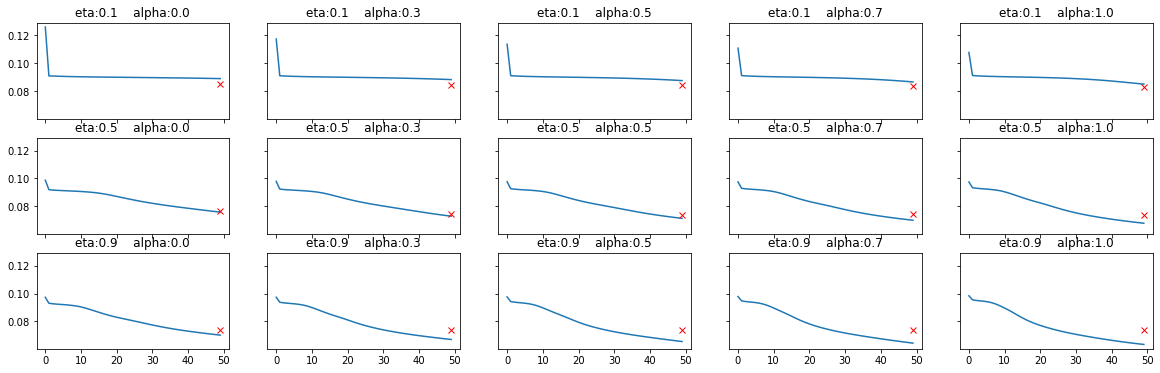

In [30]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 2,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.08522    MSE(teste):0.08090
eta:0.1    alpha:0.3    MSE(treino):0.08311    MSE(teste):0.07835
eta:0.1    alpha:0.5    MSE(treino):0.08185    MSE(teste):0.07701
eta:0.1    alpha:0.7    MSE(treino):0.08073    MSE(teste):0.07589
eta:0.1    alpha:1.0    MSE(treino):0.07905    MSE(teste):0.07436
eta:0.5    alpha:0.0    MSE(treino):0.06945    MSE(teste):0.07059
eta:0.5    alpha:0.3    MSE(treino):0.06707    MSE(teste):0.07075
eta:0.5    alpha:0.5    MSE(treino):0.06590    MSE(teste):0.07091
eta:0.5    alpha:0.7    MSE(treino):0.06504    MSE(teste):0.07116
eta:0.5    alpha:1.0    MSE(treino):0.06416    MSE(teste):0.07186
eta:0.9    alpha:0.0    MSE(treino):0.06522    MSE(teste):0.07180
eta:0.9    alpha:0.3    MSE(treino):0.06391    MSE(teste):0.07270
eta:0.9    alpha:0.5    MSE(treino):0.06342    MSE(teste):0.07348
eta:0.9    alpha:0.7    MSE(treino):0.06320    MSE(teste):0.07423
eta:0.9    alpha:1.0    M

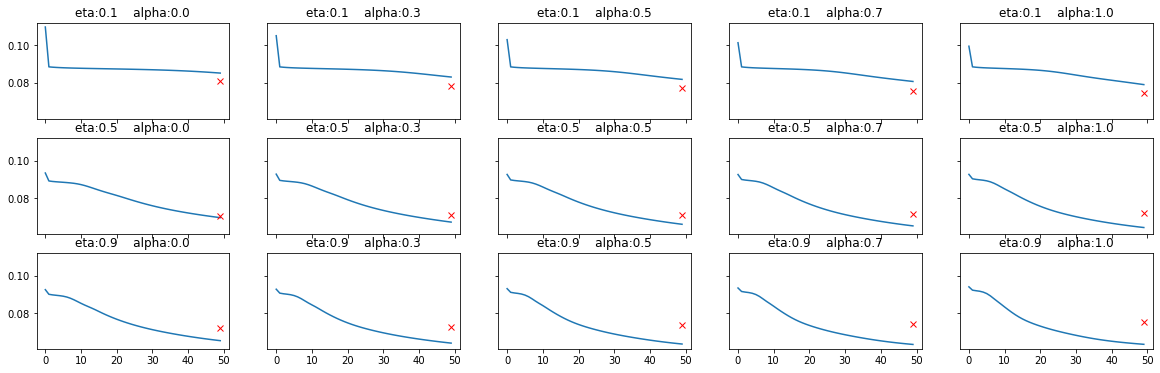

In [31]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_camadas = 2,
    seed = 100
)